# Fitting with Static spectrum (Model: theoretical spectrum)
## Objective
1. Fitting with voigt broadened theoretical spectrum
2. Save and Load fitting result
3. Retrieve or interpolate experimental spectrum based on fitting result and calculates its derivative up to 2.

In [1]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import voigt_thy, edge_gaussian
plt.rcParams["figure.figsize"] = (12,9)

## Version information

In [2]:
print(TRXASprefitpack.__version__)

0.7.0


In [3]:
# Generates fake experiment data
# Model: sum of 2 normalized theoretical spectrum

edge_type = 'g'
e0_edge = np.array([860.5, 862])
fwhm_edge = np.array([1, 1.5])
peak_shift = np.array([862.5, 863])
mixing = np.array([0.3, 0.7])
mixing_edge = np.array([0.3, 0.7])
fwhm_G_thy = 0.3
fwhm_L_thy = 0.5

thy_peak = np.empty(2, dtype=object)
thy_peak[0] = np.genfromtxt('Ni_example_1.stk')
thy_peak[1] = np.genfromtxt('Ni_example_2.stk')

# set scan range
e = np.linspace(852.5, 865, 51)

# generate model spectrum
model_static = mixing[0]*voigt_thy(e, thy_peak[0], fwhm_G_thy, fwhm_L_thy,
peak_shift[0], policy='shift')+\
    mixing[1]*voigt_thy(e, thy_peak[1], fwhm_G_thy, fwhm_L_thy,
    peak_shift[1], policy='shift')+\
        mixing_edge[0]*edge_gaussian(e-e0_edge[0], fwhm_edge[0])+\
            mixing_edge[1]*edge_gaussian(e-e0_edge[1], fwhm_edge[1])

# set noise level
eps = 1/100
# generate random noise
noise_static = np.random.normal(0, eps, model_static.size)

# generate measured static spectrum
obs_static = model_static + noise_static
eps_static = eps*np.ones_like(model_static)

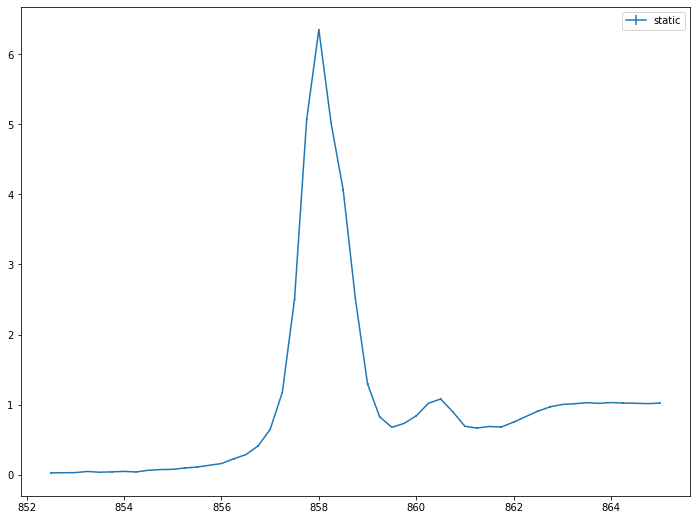

In [4]:
# plot model experimental data

plt.errorbar(e, obs_static, eps_static, label='static')
plt.legend()
plt.show()

Before fitting, we need to guess about initial peak shift paramter for theoretical spectrum

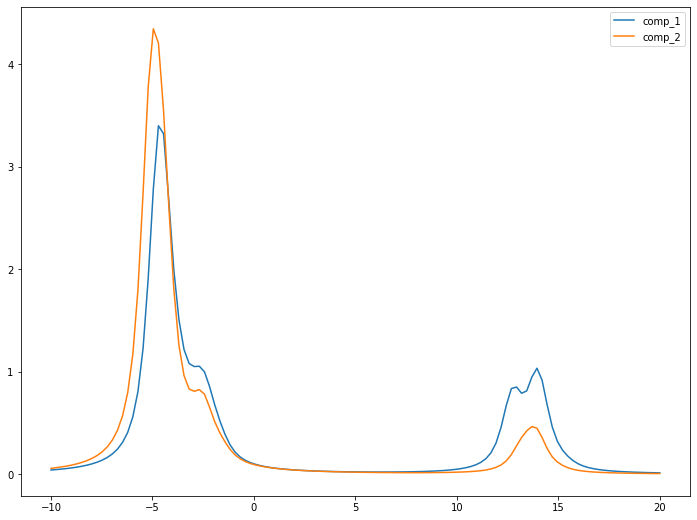

In [5]:
# Guess initial peak_shift
# check with arbitary fwhm paramter and peak_shift paramter
e_tst = np.linspace(-10, 20, 120)
comp_1 = voigt_thy(e_tst, thy_peak[0], 0.5, 1, 0, policy='shift')
comp_2 = voigt_thy(e_tst, thy_peak[1], 0.5, 1, 0, policy='shift')

plt.plot(e_tst, comp_1, label='comp_1')
plt.plot(e_tst, comp_2, label='comp_2')
plt.legend()
plt.show()


Compare first peak position, we can set initial peak shift paramter for both component as $863$, $863$.
First try with only one component

In [6]:
from TRXASprefitpack import fit_static_thy
# initial guess
policy = 'shift'
peak_shift_init = np.array([863])
fwhm_G_thy_init = 0.5
fwhm_L_thy_init = 0.5

result_1 = fit_static_thy(thy_peak[:1], fwhm_G_thy_init, fwhm_L_thy_init, 
policy, peak_shift_init, method_glb='ampgo',
e=e, intensity=obs_static, eps=eps_static)

/home/lis1331/anaconda3/lib/python3.8/site-packages/TRXASprefitpack/driver/_ampgo.py:372: RuntimeWarning: invalid value encountered in true_divide
  diff/dist
/home/lis1331/anaconda3/lib/python3.8/site-packages/TRXASprefitpack/driver/_ampgo.py:374: RuntimeWarning: divide by zero encountered in double_scalars
  y_ttf = numerator/denominator
/home/lis1331/anaconda3/lib/python3.8/site-packages/TRXASprefitpack/driver/_ampgo.py:375: RuntimeWarning: divide by zero encountered in true_divide
  deriv_y_ttf = 2*(grad_numerator/denominator +


In [7]:
print(result_1)

[Model information]
    model : thy
    policy: shift
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 592
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: Both `ftol` and `xtol` termination conditions are satisfied.
 
[Optimization Results]
    Data points: 51
    Number of effective parameters: 4
    Degree of Freedom: 47
    Chi squared:  136411.8463
    Reduced chi squared:  2902.3797
    AIC (Akaike Information Criterion statistic):  410.472
    BIC (Bayesian Information Criterion statistic):  418.1993
 
[Parameters]
    fwhm_G:  0.52095336 +/-  0.31179381 ( 59.85%)
    fwhm_L:  0.53741688 +/-  0.23583688 ( 43.88%)
    peak_shift 1:  862.66584191 +/-  0.03366347 ( 0.00%)
 
[Parameter Bound]
    fwhm_G:  0.25 <=  0.52095336 <=  1
    fwhm_L:  0.25 <=  0.53741688 <=  1
    peak_shift 1:  862.18120204 <=  862.66584191 <=  863.81879796
 
[Component Contribution]
    Static spectrum
    

Using `static_spectrum` function in TRXASprefitpack, you can directly evaluates fitted static spectrum from fitting result

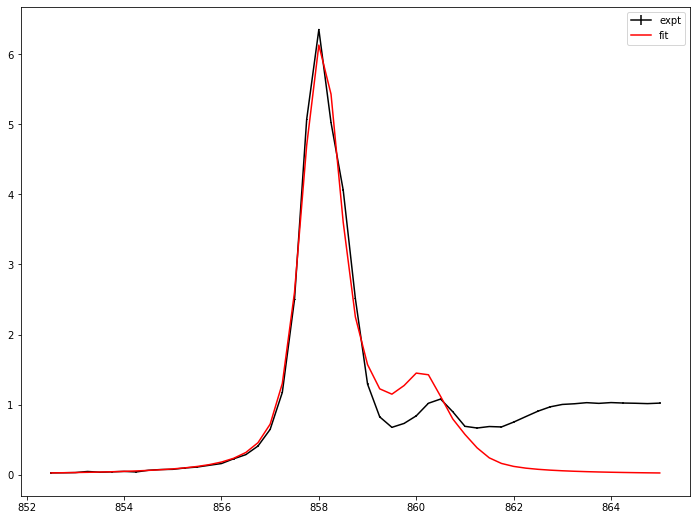

In [8]:
# plot fitting result and experimental data
from TRXASprefitpack import static_spectrum

plt.errorbar(e, obs_static, eps_static, label=f'expt', color='black')
plt.errorbar(e, static_spectrum(e, result_1), label=f'fit', color='red')

plt.legend()
plt.show()

The fit looks not good, there may exists one more component.

In [9]:
# initial guess
# add one more thoeretical spectrum
policy = 'shift'
peak_shift_init = np.array([863, 863])
# Note that each thoeretical spectrum shares full width at half maximum paramter
fwhm_G_thy_init = 0.5
fwhm_L_thy_init = 0.5

result_2 = fit_static_thy(thy_peak, fwhm_G_thy_init, fwhm_L_thy_init, 
policy, peak_shift_init, method_glb='ampgo',
e=e, intensity=obs_static, eps=eps_static)


/home/lis1331/anaconda3/lib/python3.8/site-packages/TRXASprefitpack/driver/_ampgo.py:372: RuntimeWarning: invalid value encountered in true_divide
  diff/dist
/home/lis1331/anaconda3/lib/python3.8/site-packages/TRXASprefitpack/driver/_ampgo.py:374: RuntimeWarning: divide by zero encountered in double_scalars
  y_ttf = numerator/denominator
/home/lis1331/anaconda3/lib/python3.8/site-packages/TRXASprefitpack/driver/_ampgo.py:375: RuntimeWarning: divide by zero encountered in true_divide
  deriv_y_ttf = 2*(grad_numerator/denominator +


In [10]:
print(result_2)

[Model information]
    model : thy
    policy: shift
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 1392
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: Both `ftol` and `xtol` termination conditions are satisfied.
 
[Optimization Results]
    Data points: 51
    Number of effective parameters: 6
    Degree of Freedom: 45
    Chi squared:  119084.5932
    Reduced chi squared:  2646.3243
    AIC (Akaike Information Criterion statistic):  407.544
    BIC (Bayesian Information Criterion statistic):  419.1349
 
[Parameters]
    fwhm_G:  0.25000000 +/-  0.43872563 ( 175.49%)
    fwhm_L:  0.59975490 +/-  0.20534932 ( 34.24%)
    peak_shift 1:  862.59164170 +/-  0.23524873 ( 0.03%)
    peak_shift 2:  862.98150687 +/-  0.11346975 ( 0.01%)
 
[Parameter Bound]
    fwhm_G:  0.25 <=  0.25000000 <=  1
    fwhm_L:  0.25 <=  0.59975490 <=  1
    peak_shift 1:  862.18120204 <=  862.59164170 <=  863.8

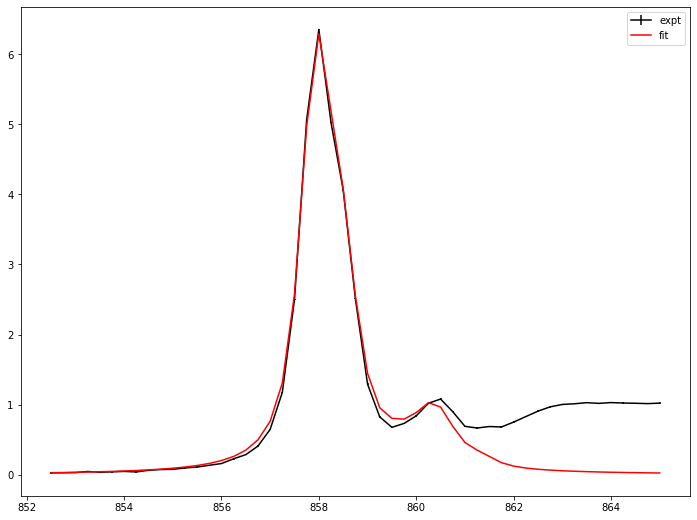

In [11]:
plt.errorbar(e, obs_static, eps_static, label=f'expt', color='black')
plt.errorbar(e, static_spectrum(e, result_2), label=f'fit', color='red')

plt.legend()
plt.show()

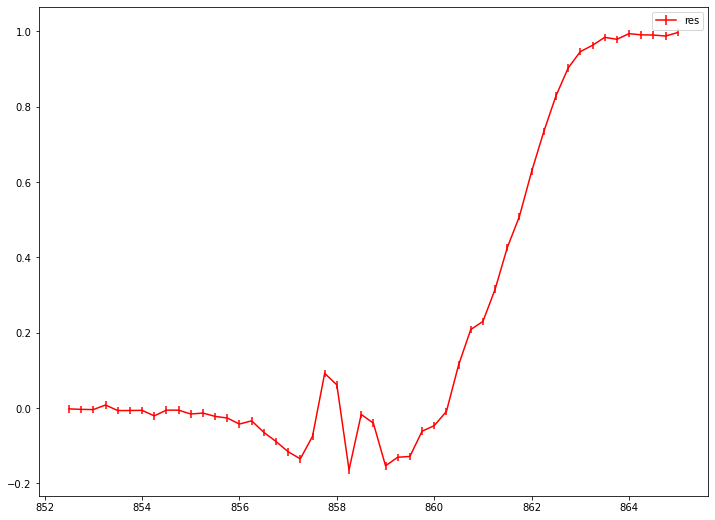

In [12]:
# plot residual
plt.errorbar(e, obs_static-static_spectrum(e, result_2), eps_static, label=f'res', color='red')

plt.legend()
plt.show()

Residual suggests that there exists gaussian edge feature near 862 with fwhm 2

In [13]:
# try with two theoretical component and edge

# refine initial guess
policy = 'shift'
peak_shift_init = np.array([862.6, 863])
# Note that each thoeretical spectrum shares full width at half maximum paramter
fwhm_G_thy_init = 0.25
fwhm_L_thy_init = 0.5
# add one edge feature
e0_edge_init = np.array([862])
fwhm_edge_init = np.array([2])

result_2_edge = fit_static_thy(thy_peak, fwhm_G_thy_init, fwhm_L_thy_init, 
policy, peak_shift_init,
edge='g', edge_pos_init=e0_edge_init, 
edge_fwhm_init=fwhm_edge_init, method_glb='ampgo',
e=e, intensity=obs_static, eps=eps_static)

In [14]:
# print fitting result
print(result_2_edge)

[Model information]
    model : thy
    policy: shift
    edge: g
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 3270
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: `xtol` termination condition is satisfied.
 
[Optimization Results]
    Data points: 51
    Number of effective parameters: 9
    Degree of Freedom: 42
    Chi squared:  89.9027
    Reduced chi squared:  2.1405
    AIC (Akaike Information Criterion statistic):  46.912
    BIC (Bayesian Information Criterion statistic):  64.2984
 
[Parameters]
    fwhm_G:  0.29976122 +/-  0.00865084 ( 2.89%)
    fwhm_L:  0.49960394 +/-  0.00633794 ( 1.27%)
    peak_shift 1:  862.50843083 +/-  0.00706934 ( 0.00%)
    peak_shift 2:  862.99673086 +/-  0.00299232 ( 0.00%)
    E0_g 1:  861.58687917 +/-  0.01733635 ( 0.00%)
    fwhm_(g, edge 1):  2.31987033 +/-  0.05701494 ( 2.46%)
 
[Parameter Bound]
    fwhm_G:  0.125 <=  0.29976122 <=  0.5
  

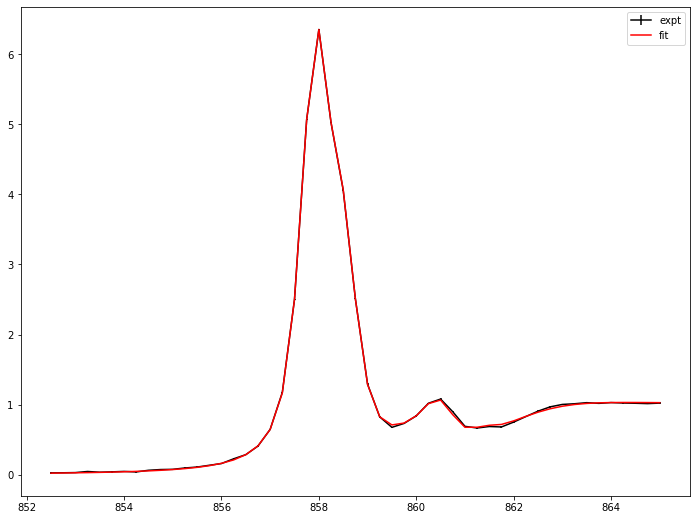

In [15]:
# plot fitting result and experimental data

plt.errorbar(e, obs_static, eps_static, label=f'expt', color='black')
plt.errorbar(e, static_spectrum(e, result_2_edge), label=f'fit', color='red')

plt.legend()
plt.show()



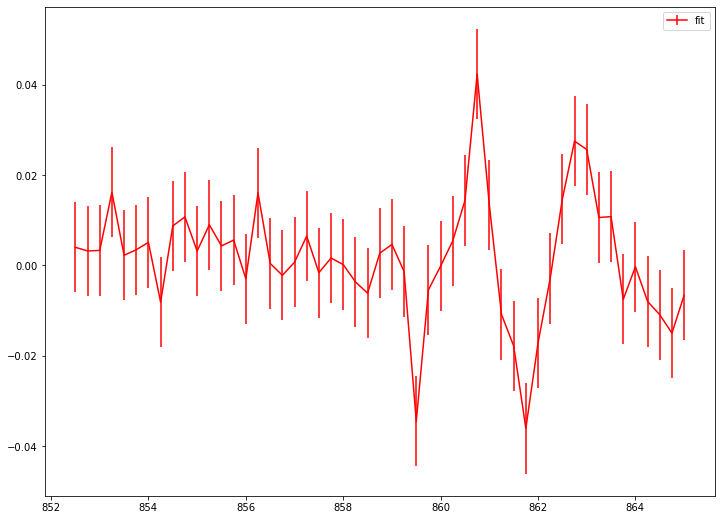

In [16]:
# plot residual
plt.errorbar(e, obs_static-static_spectrum(e, result_2_edge), eps_static, label=f'fit', color='red')

plt.legend()
plt.show()

fit_static_thy supports adding multiple edge feature, to demenstrate this I add one more edge feature in the fitting model.

In [17]:
# add one more edge

# refine initial guess
policy = 'shift'
peak_shift_init = np.array([862.6, 863])
# Note that each thoeretical spectrum shares full width at half maximum paramter
fwhm_G_thy_init = 0.25
fwhm_L_thy_init = 0.5
# add one edge feature
e0_edge_init = np.array([860.5, 862])
fwhm_edge_init = np.array([0.8, 1.5])

result_2_edge_2 = fit_static_thy(thy_peak, fwhm_G_thy_init, fwhm_L_thy_init, 
policy, peak_shift_init,
edge='g', edge_pos_init=e0_edge_init, 
edge_fwhm_init=fwhm_edge_init, method_glb='ampgo',
e=e, intensity=obs_static, eps=eps_static)

In [18]:
print(result_2_edge_2)

[Model information]
    model : thy
    policy: shift
    edge: g
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 6389
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: `xtol` termination condition is satisfied.
 
[Optimization Results]
    Data points: 51
    Number of effective parameters: 12
    Degree of Freedom: 39
    Chi squared:  23.0179
    Reduced chi squared:  0.5902
    AIC (Akaike Information Criterion statistic): -16.5732
    BIC (Bayesian Information Criterion statistic):  6.6087
 
[Parameters]
    fwhm_G:  0.29766541 +/-  0.00461112 ( 1.55%)
    fwhm_L:  0.50165657 +/-  0.00341226 ( 0.68%)
    peak_shift 1:  862.50861290 +/-  0.00383589 ( 0.00%)
    peak_shift 2:  862.99782704 +/-  0.00158692 ( 0.00%)
    E0_g 1:  861.96628745 +/-  0.04679976 ( 0.01%)
    E0_g 2:  860.44150114 +/-  0.06574437 ( 0.01%)
    fwhm_(g, edge 1):  1.54444699 +/-  0.08594562 ( 5.56%)
    fwhm_(g,

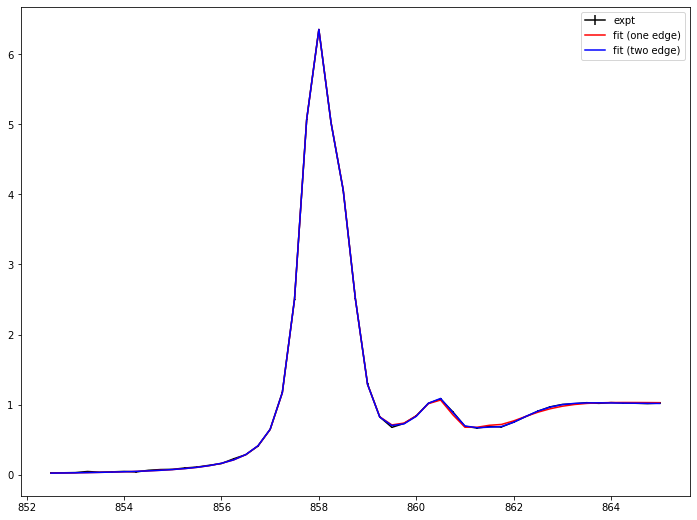

In [19]:
plt.errorbar(e, obs_static, eps_static, label=f'expt', color='black')
plt.errorbar(e, static_spectrum(e, result_2_edge), label=f'fit (one edge)', color='red')
plt.errorbar(e, static_spectrum(e, result_2_edge_2), label=f'fit (two edge)', color='blue')

plt.legend()
plt.show()

In [20]:
# save and load fitting result
from TRXASprefitpack import save_StaticResult, load_StaticResult

save_StaticResult(result_2_edge_2, 'static_example_thy') # save fitting result to static_example_thy.h5
loaded_result = load_StaticResult('static_example_thy') # load fitting result from static_example_thy.h5

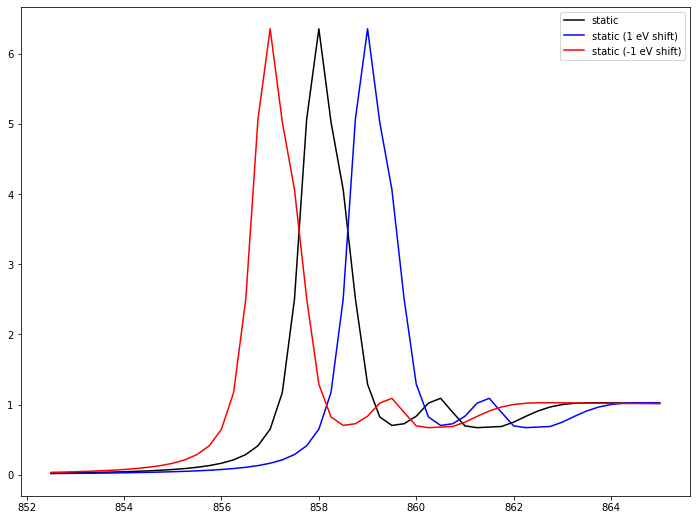

In [21]:
# plot static spectrum
plt.plot(e, static_spectrum(e, loaded_result), label='static', color='black')
plt.plot(e, static_spectrum(e-1, loaded_result), label='static (1 eV shift)', color='blue')
plt.plot(e, static_spectrum(e+1, loaded_result), label='static (-1 eV shift)', color='red')
plt.legend()
plt.show()

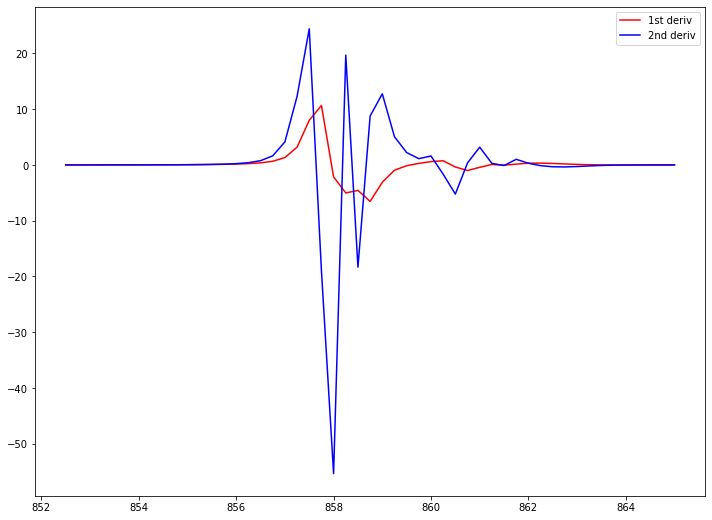

In [22]:
# plot its derivative up to second
plt.plot(e, static_spectrum(e, loaded_result, deriv_order=1), label='1st deriv', color='red')
plt.plot(e, static_spectrum(e, loaded_result, deriv_order=2), label='2nd deriv', color='blue')
plt.legend()
plt.show()

Optionally, you can calculated `F-test` based confidence interval

In [23]:
from TRXASprefitpack import confidence_interval

ci_result = confidence_interval(loaded_result, 0.05) # set significant level: 0.05 -> 95% confidence level
print(ci_result) # report confidence interval

[Report for Confidence Interval]
    Method: f
    Significance level:  5.000000e-02
 
[Confidence interval]
    0.29766541 -  0.00938656 <= fwhm_G <=  0.29766541 +  0.00919695
    0.50165657 -  0.0068657 <= fwhm_L <=  0.50165657 +  0.00680902
    862.5086129 -  0.00760942 <= peak_shift 1 <=  862.5086129 +  0.00763833
    862.99782704 -  0.00318677 <= peak_shift 2 <=  862.99782704 +  0.00321782
    861.96628745 -  0.06236662 <= E0_g 1 <=  861.96628745 +  0.11029989
    860.44150114 -  0.09856797 <= E0_g 2 <=  860.44150114 +  0.16654756
    1.54444699 -  0.182611 <= fwhm_(g, edge 1) <=  1.54444699 +  0.16610969
    1.01241472 -  0.21350814 <= fwhm_(g, edge 2) <=  1.01241472 +  0.29339317


In [24]:
# compare with ase
from scipy.stats import norm

factor = norm.ppf(1-0.05/2)

print('[Confidence interval (from ASE)]')
for i in range(loaded_result['param_name'].size):
    print(f"{loaded_result['x'][i] :.8f} - {factor*loaded_result['x_eps'][i] :.8f}", 
          f"<= {loaded_result['param_name'][i]} <=", f"{loaded_result['x'][i] :.8f} + {factor*loaded_result['x_eps'][i] :.8f}")

[Confidence interval (from ASE)]
0.29766541 - 0.00903763 <= fwhm_G <= 0.29766541 + 0.00903763
0.50165657 - 0.00668791 <= fwhm_L <= 0.50165657 + 0.00668791
862.50861290 - 0.00751821 <= peak_shift 1 <= 862.50861290 + 0.00751821
862.99782704 - 0.00311030 <= peak_shift 2 <= 862.99782704 + 0.00311030
861.96628745 - 0.09172585 <= E0_g 1 <= 861.96628745 + 0.09172585
860.44150114 - 0.12885660 <= E0_g 2 <= 860.44150114 + 0.12885660
1.54444699 - 0.16845033 <= fwhm_(g, edge 1) <= 1.54444699 + 0.16845033
1.01241472 - 0.26336392 <= fwhm_(g, edge 2) <= 1.01241472 + 0.26336392


In many case, ASE does not much different from more sophisticated `f-test` based error estimation.